# Benchmark: Elastic Collision with Material Point Method

## Particle and Background Mesh Generation:

In [1]:
import numpy as np
from scipy.spatial import Delaunay
from matplotlib import path
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [2]:
#####################################
# FEM Mesh by Delaunayn Triangulation
def pmesh(pv,hmax,nref):
    edge = len(pv)-1
    for i in range(0,edge):
        d = np.sqrt((pv[i+1,0]-pv[i,0])**2+(pv[i+1,1]-pv[i,1])**2)
        if hmax<d:
            n = int(np.ceil(d/hmax))
            nx = np.linspace(pv[i,0],pv[i+1,0],n+1)
            ny = np.linspace(pv[i,1],pv[i+1,1],n+1)
            for j in range(0,len(nx[1:-1])):
                pv = np.append(pv,[[nx[j+1],ny[j+1]]],axis=0)
    poly = pv[0:edge+1,:]
    pv = np.unique(pv,axis=0)
    a = hmax**2
    p = 0
    while (hmax**2/2.0)<a:
        tri = Delaunay(pv)
        conn = tri.simplices
        A = np.zeros(len(conn))
        for i in range(0,len(conn)):
            A[i] = np.abs(0.5*(pv[conn[i,0],0]*(pv[conn[i,1],1]-pv[conn[i,2],1])+pv[conn[i,1],0]*(pv[conn[i,2],1]-pv[conn[i,0],1])+pv[conn[i,2],0]*(pv[conn[i,0],1]-pv[conn[i,1],1])))
        C = np.zeros((len(conn),2))
        D = np.zeros((len(conn),2))
        for j in range(0,len(conn)):
            K=np.array([[2*(pv[conn[j,0],0]-pv[conn[j,1],0]), 2*(pv[conn[j,0],1]-pv[conn[j,1],1])] , [2*(pv[conn[j,1],0]-pv[conn[j,2],0]), 2*(pv[conn[j,1],1]-pv[conn[j,2],1])]])
            F=np.array([((pv[conn[j,0],0])**2-(pv[conn[j,1],0])**2)+((pv[conn[j,0],1])**2-(pv[conn[j,1],1])**2) , ((pv[conn[j,1],0])**2-(pv[conn[j,2],0])**2)+((pv[conn[j,1],1])**2-(pv[conn[j,2],1])**2)])
            c = np.linalg.inv(K).dot(F)
            C[j,:] = [c[0], c[1]]
            D[j,:] = [np.mean([(pv[conn[j,0],0]),(pv[conn[j,1],0]),(pv[conn[j,2],0])]) , np.mean([(pv[conn[j,0],1]),(pv[conn[j,1],1]),(pv[conn[j,2],1])])]
        pp = path.Path(poly)
        in_check = pp.contains_points(D)
        delete = np.where(in_check == False)
        A = np.delete(A,delete)
        C = np.delete(C,delete,axis=0)
        conn = np.delete(conn,delete,axis=0)
        if max(A)<(hmax**2/2):
            break
        else:
            ind = np.argmax(A)
            pv = np.append(pv,[[C[ind,0],C[ind,1]]],axis=0)
            pv = np.unique(pv,axis=0)
        p = p+1
    
    return pv, conn
###################################
# Regular Mesh
def regular2Dmesh(L1,h1,L2,h2):
    el1 = int(np.ceil(L1/h1))
    el2 = int(np.ceil(L2/h2))
    h1 = L1/el1
    h2 = L2/el2
    size1 = np.linspace(0,L1,el1+1)
    size2 = np.linspace(0,L2,el2+1)
    nel = el1*el2
    X1,Y1 = np.meshgrid(size1,size2)
    nodes = np.zeros((len(size1)*len(size2),2))
    k = 0
    for i in range(0,len(size2)):
        for j in range(0,len(size1)):
            nodes[k,0] = X1[i,j]
            nodes[k,1] = Y1[i,j]
            k = k+1
    conn = np.zeros(((nel,4)),dtype=int)
    for k in range(0,el2):
        for i in range(0,el1):
            conn[i+el1*k,:] = [i+(el1+1)*k, i+(el1+1)*k+1, i+(el1+1)*(k+1)+1, i+(el1+1)*(k+1)]
    return nodes,conn,el1,el2,h1,h2
##################################
def linear2Dshapefun(xi,eta):
    N = np.zeros(4)
    N[0] = 0.25*(1.0-xi)*(1.0-eta)
    N[1] = 0.25*(1.0+xi)*(1.0-eta)
    N[2] = 0.25*(1.0+xi)*(1.0+eta)
    N[3] = 0.25*(1.0-xi)*(1.0+eta)
    dN = np.zeros((2,4))
    dN[0,0] = -0.25*(1.0-eta)
    dN[0,1] =  0.25*(1.0-eta)
    dN[0,2] =  0.25*(1.0+eta)
    dN[0,3] = -0.25*(1.0+eta)
    dN[1,0] = -0.25*(1.0-xi)
    dN[1,1] = -0.25*(1.0+xi)
    dN[1,2] =  0.25*(1.0+xi)
    dN[1,3] =  0.25*(1.0-xi)
    return N,dN

In [3]:
n = 60
phi = (2*np.pi/n)*np.linspace(0,n,n+1)
pv1 = np.transpose(np.array([0.2*np.cos(phi), 0.2*np.sin(phi)]))
points,tri = pmesh(pv1,0.032,0)
set1 = (1/3.0)*np.transpose(np.array([points[tri[:,0],0]+points[tri[:,1],0]+points[tri[:,2],0],
                                      points[tri[:,0],1]+points[tri[:,1],1]+points[tri[:,2],1]]))
set1 = set1 + 0.2*np.ones((len(tri),2))
set2 = set1 + 0.6*np.ones((len(tri),2))
p_set = np.append(set1,set2,axis=0)
L1 = 1.0
L2 = 1.0
h1 = 0.05
h2 = 0.05
nodes, conn, el1, el2, h1, h2 = regular2Dmesh(L1,h1,L2,h2)
points = points + 0.2*np.ones((len(points),2))

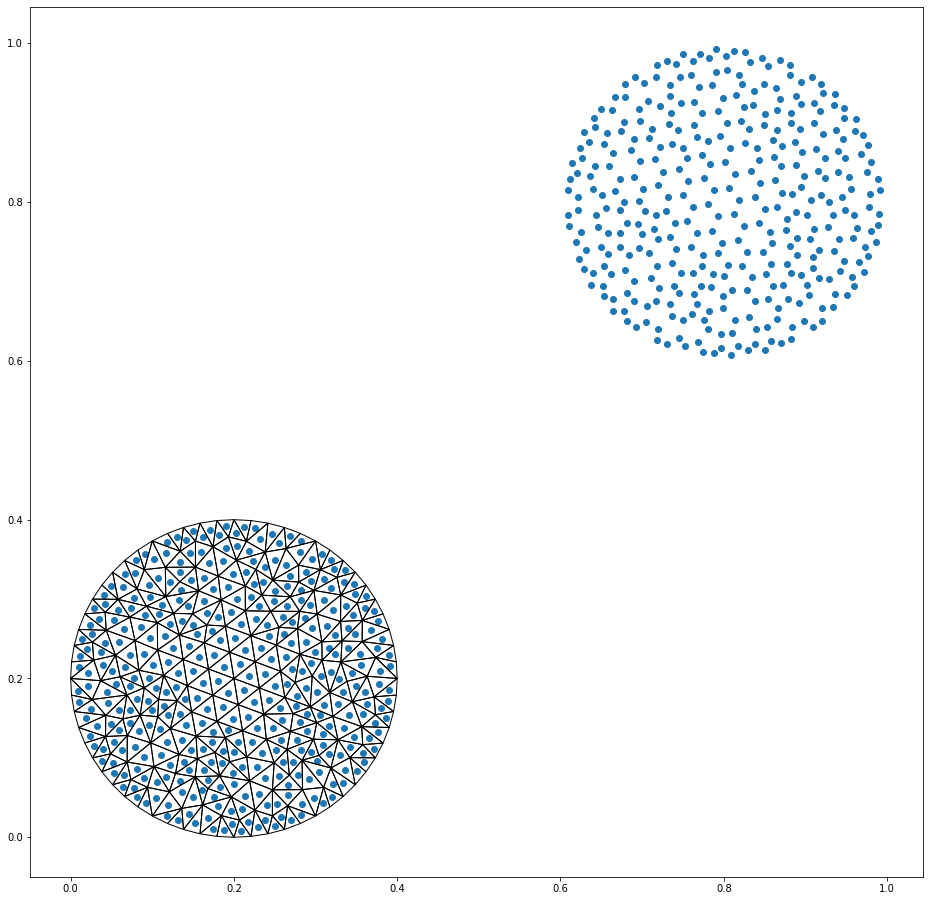

In [5]:
plt.figure(figsize=(16,16))
for i in range(0,len(tri)):
    plt.gca().add_patch(patches.Polygon([[points[tri[i,0],0],points[tri[i,0],1]],[points[tri[i,1],0],points[tri[i,1],1]],[points[tri[i,2],0],points[tri[i,2],1]]],facecolor='w',edgecolor='k',fill=False))
plt.scatter(p_set[:,0],p_set[:,1])

# Initial Configuration:

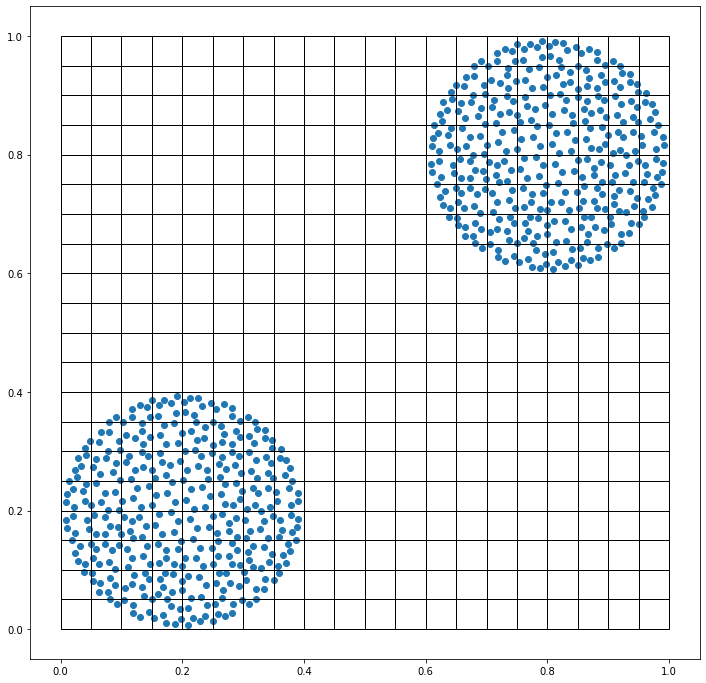

In [37]:
plt.figure(figsize=(12,12))
for i in range(0,len(conn)):
    plt.gca().add_patch(patches.Polygon([[nodes[conn[i,0],0],nodes[conn[i,0],1]],[nodes[conn[i,1],0],nodes[conn[i,1],1]],[nodes[conn[i,2],0],nodes[conn[i,2],1]],[nodes[conn[i,3],0],nodes[conn[i,3],1]]],facecolor='w',edgecolor='k',fill=False))
plt.scatter(p_set[:,0],p_set[:,1])

# MPM SIMULATION

In [6]:
E = 1000.0
nu = 0.3
C=(E/((1.+nu)*(1.-2.*nu)))*np.array([[1-nu,nu,0.], [nu,1.-nu,0.], [0.,0.,(1.-2.*nu)/2.]])
rho = 1000.0
v = 0.1
TOL = 1E-12
Vp1 = np.zeros(len(set1))
Mp1 = np.zeros(len(set1))
vp1 = np.zeros((len(set1),2))
Sp1 = np.zeros((len(set1),3))
Ep1 = np.zeros((len(set1),3))
Fp1 = np.zeros((len(set1),4))
#############################
# Initial State
for i in range(0,len(set1)):
    aMatrix = np.array([[points[tri[i,0],0],points[tri[i,0],1],1.0],
                        [points[tri[i,1],0],points[tri[i,1],1],1.0],
                        [points[tri[i,2],0],points[tri[i,2],1],1.0]])
    a = np.linalg.det(aMatrix)/2.0
    Vp1[i] = a
    Mp1[i] = a*rho
    vp1[i,:] = [v,v]
    Fp1[i,:] = [1.0,0.0,0.0,1.0]
#############################
# All Particles
Vp = np.append(Vp1,Vp1,axis=0)
Mp = np.append(Mp1,Mp1,axis=0)
vp = np.append(vp1,-1.0*vp1,axis=0)
rp = p_set
Sp = np.append(Sp1,Sp1,axis=0)
Ep = np.append(Ep1,Ep1,axis=0)
Fp = np.append(Fp1,Fp1,axis=0)
Vp0 = Vp
elNp = np.zeros(len(rp))
#############################
n_mass = np.zeros(len(nodes))
n_momentum = np.zeros((len(nodes),2))
n_fi = np.zeros((len(nodes),2))
#############################
# Simulation Parameters:
deltaT = 0.005
t = 0.0
time = 3.6
frame = 100
X = np.zeros((len(rp),frame))
Y = np.zeros((len(rp),frame))
X[:,0]=rp[:,0]
Y[:,0]=rp[:,1]
Tstep = time/frame
step = int(np.floor(Tstep/deltaT))

In [10]:
Mp

array([0.2572401 , 0.46144042, 0.47469358, 0.28325576, 0.47953806,
       0.3337202 , 0.32651669, 0.37146664, 0.3382596 , 0.48244667,
       0.3382596 , 0.28477716, 0.32503953, 0.28477716, 0.34334027,
       0.30197453, 0.47225152, 0.47579518, 0.34334027, 0.35083279,
       0.26224421, 0.28005051, 0.49010161, 0.33521047, 0.49010161,
       0.33844318, 0.47953806, 0.48244667, 0.48244667, 0.48244667,
       0.44075528, 0.32878688, 0.22302752, 0.27900051, 0.27590368,
       0.25225274, 0.37724276, 0.34389127, 0.32651669, 0.32380163,
       0.47579518, 0.47225152, 0.26129009, 0.45112454, 0.28325576,
       0.46560655, 0.34389127, 0.28005051, 0.32896429, 0.47225152,
       0.30507889, 0.34176571, 0.49010161, 0.28005051, 0.46177225,
       0.31352747, 0.29509516, 0.32878688, 0.30345168, 0.47469358,
       0.2776854 , 0.33521047, 0.49010161, 0.29327406, 0.47579518,
       0.33844318, 0.37146664, 0.45112454, 0.46560655, 0.3337202 ,
       0.27590368, 0.28173477, 0.48244667, 0.48244667, 0.36888

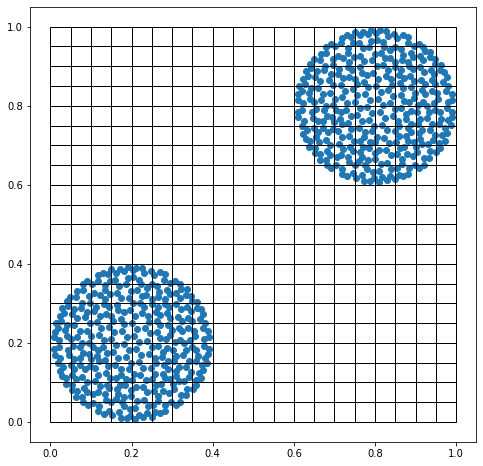

In [40]:
plt.figure(figsize=(8,8))
for i in range(0,len(conn)):
    plt.gca().add_patch(patches.Polygon([[nodes[conn[i,0],0],nodes[conn[i,0],1]],
                                         [nodes[conn[i,1],0],nodes[conn[i,1],1]],
                                         [nodes[conn[i,2],0],nodes[conn[i,2],1]],
                                         [nodes[conn[i,3],0],nodes[conn[i,3],1]]],
                                        facecolor='w',edgecolor='k',fill=False))
plt.scatter(X[:,0],Y[:,0])

In [41]:
# START
count = 0
istep = 1
while (t<=time):
    print(t)
    if ((count)%step == 0):
        if (istep<frame):
            X[:,istep]=rp[:,0]
            Y[:,istep]=rp[:,1]
            istep+=1            
    count = count + 1
    # From Particles to Nodes:
    for i in range(0,len(rp)):
        xp = rp[i,0]
        yp = rp[i,1]
        elp1 = np.ceil(xp/h1)
        elp2 = np.floor(yp/h2)
        el = int(elp2*el1+elp1-1)
        elNp[i] = el
        el_nodes = nodes[conn[el,:],:]
        xi = (2.0*xp-(el_nodes[0,0]+el_nodes[1,0]))/h1
        eta = (2.0*yp-(el_nodes[1,1]+el_nodes[2,1]))/h2
        N, dN = linear2Dshapefun(xi,eta)
        Jmatrix = np.array([[dN[0,:].dot(el_nodes[:,0]),dN[0,:].dot(el_nodes[:,1])],
                            [dN[1,:].dot(el_nodes[:,0]),dN[1,:].dot(el_nodes[:,1])]])
        J = np.linalg.det(Jmatrix)
        dNxy = np.linalg.inv(Jmatrix).dot(dN)
        #dNxy = np.linalg.solve(Jmatrix,dN)
        for j in range(0,4):
            n_mass[conn[el,j]] += N[j]*Mp[i]
            n_momentum[conn[el,j],:] += (N[j]*Mp[i])*vp[i,:]
            n_fi[conn[el,j],:] += -Vp[i]*np.array([(Sp[i,0]*dNxy[0,j]+Sp[i,2]*dNxy[1,j]),
                                                   (Sp[i,1]*dNxy[1,j]+Sp[i,2]*dNxy[0,j])])
    n_momentum += deltaT*n_fi
    #From Nodes to Particles
    for i in range(0,len(rp)):
        xp = rp[i,0]
        yp = rp[i,1]
        el = int(elNp[i])
        el_nodes = nodes[conn[el,:],:]
        xi = (2.0*xp-(el_nodes[0,0]+el_nodes[1,0]))/h1
        eta = (2.0*yp-(el_nodes[1,1]+el_nodes[2,1]))/h2
        N, dN = linear2Dshapefun(xi,eta)
        Jmatrix = np.array([[dN[0,:].dot(el_nodes[:,0]),dN[0,:].dot(el_nodes[:,1])],
                            [dN[1,:].dot(el_nodes[:,0]),dN[1,:].dot(el_nodes[:,1])]])
        J = np.linalg.det(Jmatrix)
        dNxy = np.linalg.inv(Jmatrix).dot(dN)
        #dNxy = np.linalg.solve(Jmatrix,dN)
        Lp = np.zeros((2,2))
        for j in range(0,4):
            vl = np.zeros(2)
            if (n_mass[conn[el,j]]>TOL):
                vp[i,:] += (deltaT*N[j]/n_mass[conn[el,j]])*(n_fi[conn[el,j],:])
                rp[i,:] += (deltaT*N[j]/n_mass[conn[el,j]])*n_momentum[conn[el,j],:]
                vl = n_momentum[conn[el,j],:]/n_mass[conn[el,j]]
            Lp[0,0] += vl[0]*dNxy[0,j]
            Lp[0,1] += vl[0]*dNxy[1,j]
            Lp[1,0] += vl[1]*dNxy[0,j]
            Lp[1,1] += vl[1]*dNxy[1,j]
        F = (np.array([[1,0],[0,1]])+deltaT*Lp).dot(np.array([[Fp[i,0],Fp[i,1]],[Fp[i,2],Fp[i,3]]]))
        Fp[i,:] = [F[0,0],F[0,1],F[1,0],F[1,1]]
        Vp[i] = np.linalg.det(np.array([[Fp[i,0],Fp[i,1]],[Fp[i,2],Fp[i,3]]]))*Vp0[i]
        dEps = (0.5*deltaT)*(Lp+np.transpose(Lp))
        dSigma = C.dot(np.array([dEps[0,0],dEps[1,1],2*dEps[0,1]]))
        Sp[i,:] += [dSigma[0], dSigma[1], dSigma[2]]
        Ep[i,:] += [dEps[0,0],dEps[1,1],2.*dEps[0,1]]
    t += deltaT
    n_mass = 0*n_mass
    n_momentum = 0*n_momentum;
    n_fi = 0*n_fi;

0.0
0.005
0.01
0.015
0.02
0.025
0.030000000000000002
0.035
0.04
0.045
0.049999999999999996
0.05499999999999999
0.05999999999999999
0.06499999999999999
0.06999999999999999
0.075
0.08
0.085
0.09000000000000001
0.09500000000000001
0.10000000000000002
0.10500000000000002
0.11000000000000003
0.11500000000000003
0.12000000000000004
0.12500000000000003
0.13000000000000003
0.13500000000000004
0.14000000000000004
0.14500000000000005
0.15000000000000005
0.15500000000000005
0.16000000000000006
0.16500000000000006
0.17000000000000007
0.17500000000000007
0.18000000000000008
0.18500000000000008
0.19000000000000009
0.1950000000000001
0.2000000000000001
0.2050000000000001
0.2100000000000001
0.2150000000000001
0.2200000000000001
0.22500000000000012
0.23000000000000012
0.23500000000000013
0.24000000000000013
0.24500000000000013
0.2500000000000001
0.2550000000000001
0.2600000000000001
0.2650000000000001
0.27000000000000013
0.27500000000000013
0.28000000000000014
0.28500000000000014
0.29000000000000015
0.

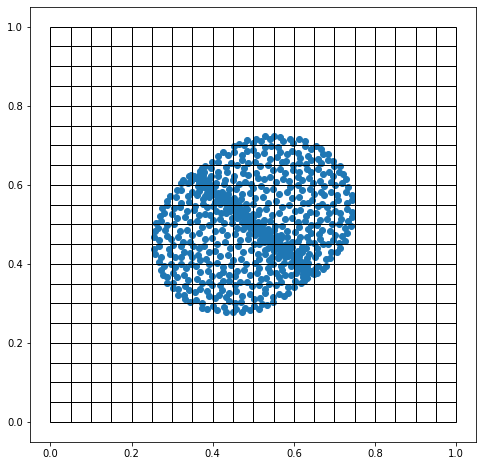

In [42]:
plt.figure(figsize=(8,8))
for i in range(0,len(conn)):
    plt.gca().add_patch(patches.Polygon([[nodes[conn[i,0],0],nodes[conn[i,0],1]],[nodes[conn[i,1],0],nodes[conn[i,1],1]],[nodes[conn[i,2],0],nodes[conn[i,2],1]],[nodes[conn[i,3],0],nodes[conn[i,3],1]]],facecolor='w',edgecolor='k',fill=False))
plt.scatter(X[:,80],Y[:,80])

In [43]:
Vp0

array([1.65850674e-005, 7.35382469e-023, 2.26818570e-014, 3.66863896e-004,
       1.43094552e-004, 1.08457787e-307, 1.71621607e-318, 4.06745164e-122,
       3.22560795e-112, 4.51395384e-028, 4.84297793e-224, 1.49901305e-238,
       1.51865753e-261, 1.83009554e-264, 1.70467928e-282, 3.99922889e-307,
       0.00000000e+000, 0.00000000e+000, 4.80484127e-256, 1.82220149e-004,
       3.75258228e-004, 1.79251129e-004, 5.12869200e-004, 1.28993053e-004,
       4.34969197e-004, 2.60875918e-004, 1.01123646e-004, 1.12364712e-026,
       1.33049754e-032, 6.36317968e-038, 2.43941771e-014, 5.49474434e-017,
       4.84680958e-004, 3.91221908e-009, 2.81919082e-006, 7.30666368e-046,
       1.51795215e-021, 2.54248914e-029, 2.97001547e-031, 1.00385407e-080,
       1.19764380e-054, 5.69356440e-031, 7.57857829e-064, 7.46501645e-066,
       1.26478356e-128, 1.08572414e-093, 2.26039975e-004, 1.94981065e-004,
       7.31643211e-004, 6.08330663e-005, 2.41697035e-004, 2.52079529e-004,
       2.01712375e-009, 5

In [ ]:
a = np.ones((2,4))
a[0][0] = 1
a[1][0] = 2

In [ ]:
a

In [ ]:
b = np.ones((4,2))
b[0] = 3
b[1] = 1

In [ ]:
a[0,:]/3

In [ ]:
a[0,:].dot(b[:,0])

In [ ]:
c = np.transpose(a).dot(b)

In [ ]:
c[0]

In [55]:
i = 1

In [56]:
i +=1

In [57]:
i

2